5_best_features: accuracy =  0.7441289784299772
10_best_features: accuracy =  0.8090108218203235
20_best_features: accuracy =  0.8444700743540036
40_best_features: accuracy =  0.856494319157812
80_best_features: accuracy =  0.8627763735859243


/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


86_best_features: accuracy =  0.8613530956295551


/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


80_best_features presented the best accuracy: 0.8627763735859243


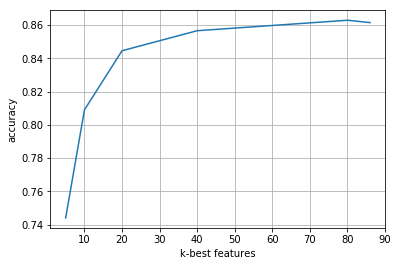

In [3]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
import time
from sklearn.externals import joblib
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

tcontext = 120
best_accuracy = 0
k_features = [5, 10, 20, 40, 80, 86]
best_k = k_features[0]
accuracies = list()

for k in k_features:

    # Load features
    features = np.load('features_tcontext_' + str(tcontext) + '_frameSize_1024.npz')
    features = features['a']
    features += np.finfo(np.float32).eps
    labels = features[:,-1].astype(int)
    features = features[:, :features.shape[1] - 1]

    with open("features_length.txt", 'r') as f:
        features_length = [line.rstrip('\n') for line in f]

    features_names = list()
    for i in features_length:
        marker = i.find(':')
        f_name = i[:marker]
        values = int(i[marker+2:])
        for j in range(values):
            features_names.append(f_name + str('_')+ str(j))

    # Prepare data
    imputer = SimpleImputer()
    features = imputer.fit_transform(features)
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels)
    
    # Split data
    features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.2, random_state = 42)
    features_train_df = pd.DataFrame(data = features_train, columns = features_names)
    features_val_df = pd.DataFrame(data = features_val, columns = features_names)
    # Select best k features
    selector = SelectKBest(f_classif, k=k)
    selector.fit(features_train_df, labels_train)
    # Get columns to keep
    cols = selector.get_support(indices=True)
    cols = [features_names[i] for i in cols]
    
    # Parameters
    estimators = [('scale', preprocessing.StandardScaler()),
                      ('anova_filter', SelectKBest(f_classif, k=k)),
                      ('svm', svm.SVC(decision_function_shape='ovo'))]
    
    clf_svm = Pipeline(estimators)
    start = time.time()
    
    # Training
    clf_svm.fit(features_train, labels_train)
    # Validation
    pred_svm = clf_svm.predict(features_val)
    
    model_filename = './tcontext_'+ str(tcontext) + '/models/svm/svm_' + str(k)  + '_best_features.sav'
    joblib.dump(clf_svm, open(model_filename, 'wb'))
    
    end = time.time()
    elapsed_time = end-start

    F = open('./tcontext_'+ str(tcontext) +'/results/svm/results_kBestFeatures_' + str(k) +  '.txt','w') 
    F.write('Model trained in: ' + str(int(elapsed_time/60)) + ' minutes and ' + str(round(elapsed_time%60, 2)) + ' seconds \n\n')
    F.write('K Best Features using f_classif: ' + str(k) + '\n\n')
    F.write('Best features: ' + str(cols) + '\n\n')
    F.write('Confusion matrix: \n\n')
    F.write(str(confusion_matrix(labels_val,pred_svm)))
    F.write('\n\n')
    F.write('Classification report: \n\n')
    F.write(str(classification_report(labels_val,pred_svm)))
    F.write('\n\n')
    F.write('Accuracy: ' + str(accuracy_score(labels_val, pred_svm)))
    F.close()
    
    # Update best accuracy if improved
    if (accuracy_score(labels_val, pred_svm) > best_accuracy):
        best_accuracy = accuracy_score(labels_val, pred_svm)
        best_k = k
    accuracies.append(accuracy_score(labels_val, pred_svm))
    print(str(k) + '_best_features: accuracy =  ' + str(accuracy_score(labels_val, pred_svm)))

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(k_features, accuracies)
plt.xlabel('k-best features')
plt.ylabel('accuracy')
ax.grid('on')
plt.savefig('./tcontext_' + str(tcontext) + '/results/svm/accuracies.png', bbox_inches='tight')

print(str(best_k) + '_best_features presented the best accuracy: ' + str(best_accuracy))
F_best = open('./tcontext_' + str(tcontext) + '/results/svm/best_svm_model.txt','w')
F_best.write(str(best_k) + '_best_features presented the best accuracy: ' + str(best_accuracy))
F_best.close()